In [2]:
from torch.nn import Sequential
from torch.nn import Linear, Dropout, ReLU
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import MSELoss, HuberLoss
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import json
import os

from Module.MySQL_connector import MySQLConnector

In [27]:
import torch

from torch.optim import SGD

class SimpleTrainer:
    """A model trainer for regression models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)

    def train_step(self, dataloader):
        """訓練一個epoch，並計算 R²。"""
        self.model.train()  # 設定成訓練模式
        total_loss = 0  # 累積所有 batch 的損失
        total_r2 = 0  # 累積所有 batch 的 R²

        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)

            self.optimizer.zero_grad()  # 清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測

            loss_value = self.loss_fn(pred_y, batch_y)  # 計算損失

            # for weight in self.model.parameters():
            #     loss_value += 0.01* torch.sum(weight**2)
            #     # print(loss_value,  torch.sum(weight)**2)

            loss_value.backward()  # 反向傳遞
            self.optimizer.step()  # 更新權重

            total_loss += loss_value.item()  # 累積損失

            # 计算 R²
            ss_total = torch.sum((batch_y - torch.mean(batch_y)) ** 2)
            ss_residual = torch.sum((batch_y - pred_y) ** 2)
            # r2 = 1 - ss_residual / ss_total
            
            if ss_total.item() == 0:
                r2 = 0  # 防止分母为0
            else:
                r2 = 1 - ss_residual / ss_total
            total_r2 += r2.item()
        avg_loss = total_loss / len(dataloader)  # 計算平均損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"Train loss: {avg_loss:.4f}, Train R²: {avg_r2:.4f}")
        return avg_loss, avg_r2

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        size = len(dataloader.dataset)
        test_loss = 0
        total_r2 = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)

                # 计算损失
                test_loss += self.loss_fn(pred_y, batch_y).item()

                # 计算 R²
                ss_total = torch.sum((batch_y - torch.mean(batch_y)) ** 2)
                ss_residual = torch.sum((batch_y - pred_y) ** 2)
                r2 = 1 - ss_residual / ss_total
                total_r2 += r2.item()

        avg_test_loss = test_loss / len(dataloader)  # 計算平均測試損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"{mode}_loss={avg_test_loss:.4f}, {mode}_R²={avg_r2:.4f}")
        return avg_test_loss, avg_r2

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_loss": [], "test_loss": [], "train_r2": [], "test_r2": []}
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_r2 = self.train_step(dataloader_train)
            test_loss, test_r2 = self.test_step(dataloader_test)

            metrics["train_loss"].append(train_loss)
            metrics["test_loss"].append(test_loss)
            metrics["train_r2"].append(train_r2)
            metrics["test_r2"].append(test_r2)

        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理模式
        return self.model(x)  # 執行推理


In [44]:
import torch
from torch.optim import SGD
from torchmetrics import R2Score  # 引入 torchmetrics

class SimpleTrainer:
    """A model trainer for regression models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.r2_metric = R2Score().to("cuda:0")  # 初始化 R2Score

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)

    def train_step(self, dataloader):
        """訓練一個epoch，並計算 R²。"""
        self.model.train()  # 設定成訓練模式
        total_loss = 0  # 累積所有 batch 的損失
        total_r2 = 0  # 累積所有 batch 的 R²

        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)

            self.optimizer.zero_grad()  # 清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測
              # 去掉多餘的維度
            pred_y = pred_y.squeeze(-1)
            loss_value = self.loss_fn(pred_y, batch_y)  # 計算損失

            loss_value.backward()  # 反向傳遞
            self.optimizer.step()  # 更新權重

            total_loss += loss_value.item()  # 累積損失
            
            # 使用 torchmetrics 計算 R²
            r2 = self.r2_metric(pred_y, batch_y)
            total_r2 += r2.item()

        avg_loss = total_loss / len(dataloader)  # 計算平均損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"Train loss: {avg_loss:.4f}, Train R²: {avg_r2:.4f}")
        return avg_loss, avg_r2

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        test_loss = 0
        total_r2 = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)
                pred_y = pred_y.squeeze(-1)
                # 计算损失
                test_loss += self.loss_fn(pred_y, batch_y).item()

                # 使用 torchmetrics 計算 R²
                r2 = self.r2_metric(pred_y, batch_y)
                total_r2 += r2.item()

        avg_test_loss = test_loss / len(dataloader)  # 計算平均測試損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"{mode}_loss={avg_test_loss:.4f}, {mode}_R²={avg_r2:.4f}")
        return avg_test_loss, avg_r2

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_loss": [], "test_loss": [], "train_r2": [], "test_r2": []}
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_r2 = self.train_step(dataloader_train)
            test_loss, test_r2 = self.test_step(dataloader_test)

            metrics["train_loss"].append(train_loss)
            metrics["test_loss"].append(test_loss)
            metrics["train_r2"].append(train_r2)
            metrics["test_r2"].append(test_r2)

        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理模式
        return self.model(x)  # 執行推理


In [49]:
full_table = pd.read_csv("../../data/processed/raw_table_mldl.csv")

In [59]:
full_table = pd.read_csv("../../data/processed/full_data_for_ml.csv")

In [60]:
full_table = full_table.drop(columns=["Unnamed: 0","steamId"])

In [51]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

full_table['publishedGames'] = np.log1p(full_table['publishedGames'])
full_table['medianRevenue'] = np.log1p(full_table['medianRevenue'])
full_table['averageRevenue'] = np.log1p(full_table['averageRevenue'])
# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames", "medianRevenue", "averageRevenue"]

# 對指定欄位進行 Min-Max 轉換
full_table[columns_to_scale] = scaler.fit_transform(full_table[columns_to_scale])
# full_table['sales'] = np.log1p(full_table['sales'])
# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_table.head())

           sales  averageRevenue  medianRevenue  publishedGames     price  \
0    4464.555556        0.453316       0.587113        0.466248  0.049952   
1  711776.000000        0.762018       0.493235        0.227723  0.149957   
2     495.433333        0.333886       0.521493        0.000000  0.024951   
3      38.000000        0.450807       0.620089        0.166560  0.049952   
4  103633.000000        0.762480       0.829376        0.073704  0.099955   

   earlyAccess  Accounting  Action  Adventure  Animation & Modeling  ...  \
0            0           0       0          0                     0  ...   
1            0           0       0          0                     0  ...   
2            0           0       0          0                     0  ...   
3            0           0       0          0                     0  ...   
4            0           0       1          1                     0  ...   

   Steam Timeline  Steam Trading Cards  Steam Turn Notifications  \
0           

In [68]:
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values

In [62]:
full_table['sales'] = full_table['sales'].round(2)
full_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.40,0.453316,0.587113,0.466248,0.451984,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,13.48,0.762018,0.493235,0.227723,0.647464,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6.21,0.333886,0.521493,0.000000,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,3.66,0.450807,0.620089,0.166560,0.451984,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,11.55,0.762480,0.829376,0.073704,0.573996,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,3.61,0.000000,0.186124,0.656380,0.129757,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
17786,4.34,0.234036,0.347340,0.479719,0.260932,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,7.48,0.271885,0.492761,0.125998,0.303104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,2.77,0.214907,0.398674,0.498221,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [147]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)。。
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 25)
print(X_train_full.dtype)
print(y_train_full.dtype)
X_train_full = np.array(X_train_full, dtype=np.float32)
y_train_full = np.array(y_train_full, dtype=np.float32)
X_test_full = np.array(X_test_full, dtype=np.float32)
y_test_full = np.array(y_test_full, dtype=np.float32)
print(X_train_full.dtype)
print(y_train_full.dtype)


object
float64
float32
float32


In [148]:
x_train, y_train = torch.tensor(X_train_full), torch.tensor(y_train_full)
x_test, y_test = torch.tensor(X_test_full), torch.tensor(y_test_full)
x_train = x_train.to(torch.float32)
x_test = x_test.to(torch.float32)
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)
# 將PyTorch tensor 製作成 Data Loader
td = TensorDataset(x_train, y_train)
dl_train = DataLoader(td, batch_size=512, shuffle=True)
# Shuffle 隨機打亂數據，防止模型過度依賴數據的順序，從而提高模型的泛化能力。
td = TensorDataset(x_test, y_test)
dl_test = DataLoader(td, batch_size=512, shuffle=False)

In [138]:
for x_batch, y_batch in dl_train:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([1024, 487]) torch.Size([1024])


In [149]:
print(f"Shape of X_train:{X_train_full.shape}")
print(f"Shape of X_test:{X_test_full.shape}")
print(f"Shape of y_train:{y_train_full.shape}")
print(f"Shape of y_test{y_test_full.shape}")

Shape of X_train:(14232, 487)
Shape of X_test:(3558, 487)
Shape of y_train:(14232,)
Shape of y_test(3558,)


In [163]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# 假設 model 是你的 PyTorch 模型



In [161]:
from torch import nn
layers = [ 
    Linear(487, 1024),  # 增加神經元數量
    ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.5),
    Linear(1024, 512),
    ReLU(),# 增加一層
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    Linear(512, 256),
    ReLU(),
    nn.BatchNorm1d(256),
    # nn.Dropout(p=0.5),
    Linear(256, 1)
]
model = Sequential(*layers)

In [164]:

# 宣告模型訓練設定
num_epochs = 500
learning_rate = 0.0001
reset_model_weights(model)
# 定義優化器, Loss函數
loss = MSELoss()
# loss= torch.nn.SmoothL1Loss()
opt = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 開始訓練模|型

model = SimpleTrainer(model, loss, opt)
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

Epoch 1/500
Train loss: 48.1759, Train R²: -7.0410
test_loss=53.6788, test_R²=-7.8412
Epoch 2/500
Train loss: 46.7054, Train R²: -6.7919
test_loss=46.9125, test_R²=-6.7315
Epoch 3/500
Train loss: 46.1010, Train R²: -6.6956
test_loss=45.4644, test_R²=-6.4952
Epoch 4/500
Train loss: 45.6261, Train R²: -6.6299
test_loss=45.0412, test_R²=-6.4264
Epoch 5/500
Train loss: 45.1090, Train R²: -6.5263
test_loss=44.4010, test_R²=-6.3211
Epoch 6/500
Train loss: 44.5021, Train R²: -6.4341
test_loss=43.9051, test_R²=-6.2397
Epoch 7/500
Train loss: 43.8901, Train R²: -6.3224
test_loss=43.3795, test_R²=-6.1539
Epoch 8/500
Train loss: 43.0969, Train R²: -6.1911
test_loss=43.0362, test_R²=-6.0967
Epoch 9/500
Train loss: 42.3181, Train R²: -6.0718
test_loss=42.1771, test_R²=-5.9553
Epoch 10/500
Train loss: 41.4512, Train R²: -5.8971
test_loss=40.8772, test_R²=-5.7403
Epoch 11/500
Train loss: 40.4139, Train R²: -5.7371
test_loss=39.8519, test_R²=-5.5721
Epoch 12/500
Train loss: 39.2603, Train R²: -5.5487


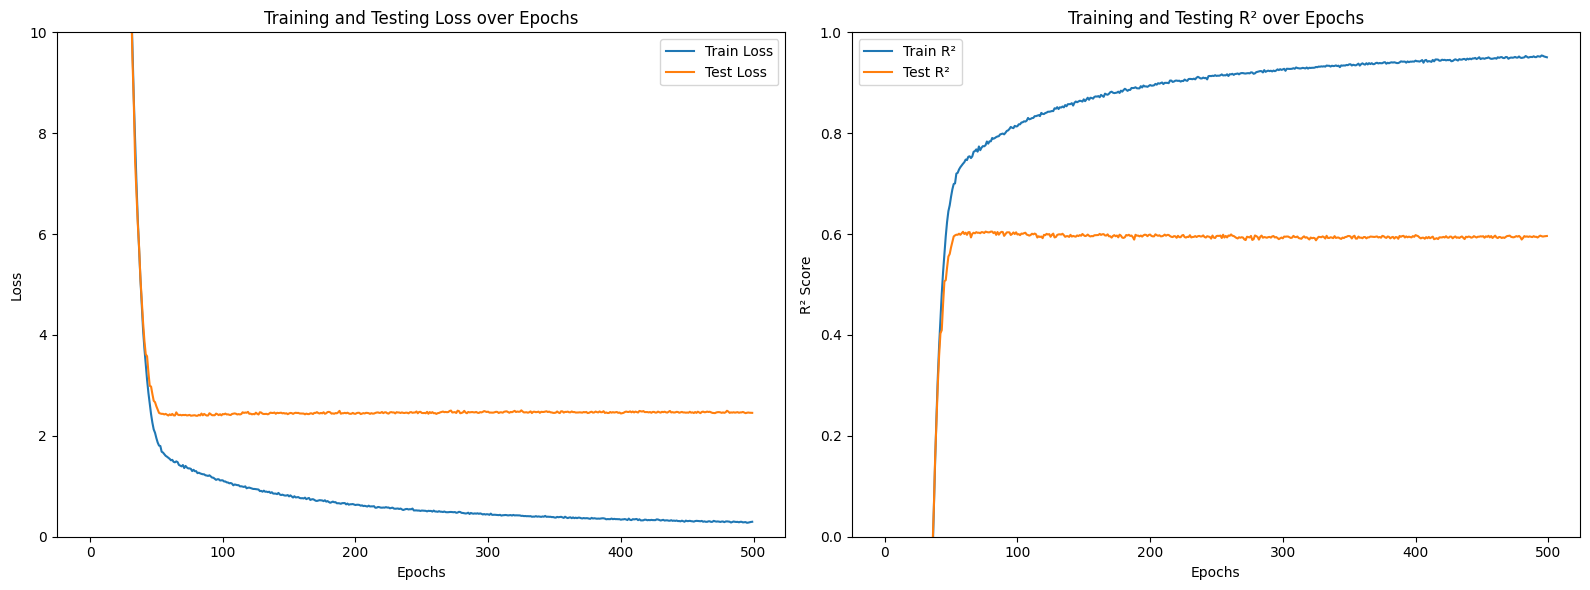

In [165]:
import matplotlib.pyplot as plt

# 假设 metrics 字典已经有 'train_loss' 和 'test_loss'
# 这些是从 trainer.fit() 返回的
train_loss = metrics["train_loss"]
test_loss = metrics["test_loss"]
train_r2 = metrics["train_r2"]
test_r2 = metrics["test_r2"]

# 創建兩個子圖：一個顯示損失，另一個顯示 R²
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 第一張圖：訓練損失和測試損失
axs[0].plot(train_loss, label="Train Loss")
axs[0].plot(test_loss, label="Test Loss")
axs[0].set_title("Training and Testing Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim(0, 10)
axs[0].legend()

# 第二張圖：訓練 R² 和測試 R²
axs[1].plot(train_r2, label="Train R²")
axs[1].plot(test_r2, label="Test R²")
axs[1].set_title("Training and Testing R² over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("R² Score")
axs[1].set_ylim(0, 1)
# axs[1].set_xlim(0, 500)
axs[1].legend()

# 顯示圖表
plt.tight_layout()
plt.show()


In [36]:
full_table.drop(columns="sales")

array([[0.01163047, 0.00232218, 0.6961326 , ..., 0.        , 0.        ,
        0.        ],
       [0.01163047, 0.00232218, 0.6961326 , ..., 0.        , 0.        ,
        0.        ],
       [0.10086137, 0.09390121, 0.03867403, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01455339, 0.00300526, 0.26519337, ..., 0.        , 0.        ,
        0.        ],
       [0.00476716, 0.00174412, 0.27071823, ..., 0.        , 0.        ,
        0.        ],
       [0.00424864, 0.00119572, 0.48066298, ..., 0.        , 0.        ,
        0.        ]])

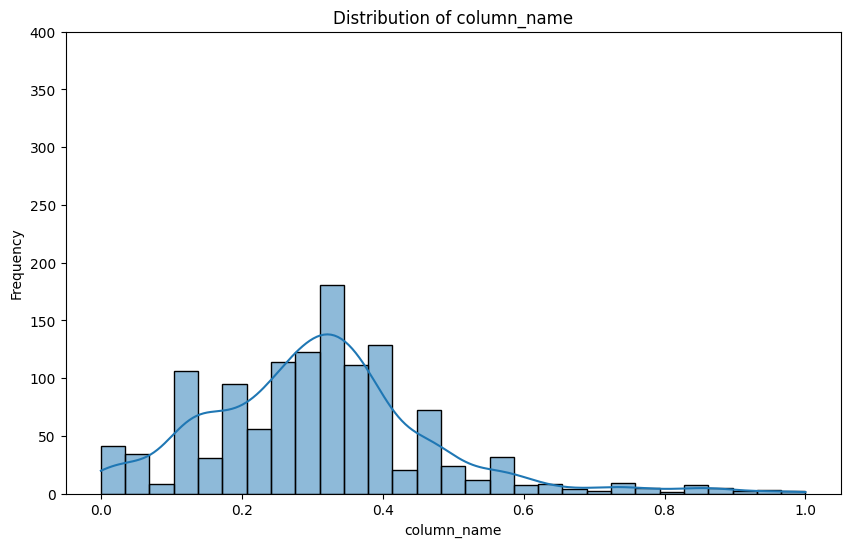

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你要繪製 df['column_name'] 的分布
plt.figure(figsize=(10, 6))
sns.histplot(full_table.drop(columns="sales")["medianRevenue"], kde=True)  # kde=True 可以添加密度估計曲線
plt.title('Distribution of column_name')
plt.xlabel('column_name')
plt.ylabel('Frequency')
plt.ylim(0, 400)
plt.show()

In [44]:
full_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Action,Adventure,Casual,Early Access,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled
0,0.000000,0.011630,0.002322,0.696133,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.949297,0.011630,0.002322,0.696133,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.098669,0.100861,0.093901,0.038674,0.249906,0,1,1,0,0,...,1,1,1,0,0,0,0,0,0,0
3,13.910367,0.054163,0.009294,0.055249,0.499937,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,10.895628,0.027177,0.010831,0.187845,0.249906,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,13.865232,0.036138,0.025433,0.033149,0.099887,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1240,8.429891,0.004767,0.001744,0.270718,0.749969,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1241,11.482043,0.014553,0.003005,0.265193,0.249906,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1242,7.859799,0.004767,0.001744,0.270718,0.499937,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
